In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("reshape2")
library("pheatmap")
library("scales")
library("ggplot2")
library("ggrepel")
library("ggsignif")
library("parallel")


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




Load the metadata

In [3]:
snv_info <- fread("Data/snv_loci_v2.csv")
snvIDs <- snv_info[,SNVID]
mito_barcodes <- fread("Data/mito_barcodes.csv")
mitoIDs <- mito_barcodes[, ID] 

chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmbases <- chrmbases_properties[, ref]
nchrmbases <- length(chrmbases)

MitoInfo <- fread("Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]
MitoInfo[, CellID := factor(CellID)]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df[, "LibraryMitoID"]

CellInfo <- fread("Report/metadata/CellInfo.csv")
CellInfo_df <- as.data.frame(CellInfo)
rownames(CellInfo_df) <- CellInfo_df$CellUID

MouseInfo <- fread("Report/metadata/MouseInfo.csv")
MouseInfo_df <- as.data.frame(MouseInfo)
rownames(MouseInfo_df) <- MouseInfo_df$MouseID

Load the data

In [4]:
inherited_altperc_bymito_byposmut <- fread(file = "Report/SNVs/origin/highdepth_inherited_altperc_bymito_byposmut.csv.gz")

inherited_noctrl_altperc_bymito_byposmut <- inherited_altperc_bymito_byposmut[IsCtrl == "N"]
inherited_noctrl_altperc_bymito_byposmut[, CellTypeID := paste0(CellType, "_", CellID)]
dim(inherited_noctrl_altperc_bymito_byposmut)

[1] 1633  181

In [5]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
inherited_posmuts <- support_byposmut[nmice >= 3, posmut]
mito_metacnames <- names(inherited_noctrl_altperc_bymito_byposmut)[!names(inherited_noctrl_altperc_bymito_byposmut) %in% inherited_posmuts]

arcsin VAF per mito

In [ ]:
inherited_noctrl_altasin_bymito_byposmut <- inherited_noctrl_altperc_bymito_byposmut[, data.table(inherited_noctrl_altperc_bymito_byposmut[, mito_metacnames, with = FALSE], apply(.SD, 2, Stats$parcsin)), .SDcols = inherited_posmuts]
fwrite(inherited_noctrl_altasin_bymito_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasin_bymito_byposmut.csv")

arcsin VAF per cell

In [ ]:
inherited_noctrl_altasin_bycell_byposmut <- inherited_noctrl_altasin_bymito_byposmut[, { x <- colMeans(.SD[, inherited_posmuts, with = FALSE], na.rm = TRUE); x[is.nan(x)] <- NA; data.table(t(x)) }, by = "CellUID"]
inherited_noctrl_altasin_bycell_byposmut <- CellInfo[inherited_noctrl_altasin_bycell_byposmut, on = "CellUID"]
cell_metacnames <- names(inherited_noctrl_altasin_bycell_byposmut)[!names(inherited_noctrl_altasin_bycell_byposmut) %in% inherited_posmuts]
fwrite(inherited_noctrl_altasin_bycell_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasin_bycell_byposmut.csv")

arcsin VAF per mouse

In [ ]:
inherited_noctrl_altasin_bymouse_byposmut <- inherited_noctrl_altasin_bycell_byposmut[, { x <- colMeans(.SD[, inherited_posmuts, with = FALSE], na.rm = TRUE); x[is.nan(x)] <- NA; data.table(t(x)) }, by = "MouseID"]
inherited_noctrl_altasin_bymouse_byposmut <- MouseInfo[inherited_noctrl_altasin_bymouse_byposmut, on = "MouseID"]
mouse_metacnames <- names(inherited_noctrl_altasin_bymouse_byposmut)[!names(inherited_noctrl_altasin_bymouse_byposmut) %in% inherited_posmuts]
fwrite(inherited_noctrl_altasin_bymouse_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasin_bymouse_byposmut.csv")

arcsin VAF per mito (centered around the cell mean)

In [ ]:
inherited_noctrl_altasinctrd_bymito_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_altasin_bymito_byposmut[, .(permito = get(posmut), LibraryMitoID, CellUID)]
    Y <- inherited_noctrl_altasin_bycell_byposmut[, .(percell = get(posmut), CellUID)]
    Z <- merge.data.table(X, Y, by = "CellUID", all.x = TRUE)
    setkey(Z, LibraryMitoID)
    Z[J(inherited_noctrl_altasin_bymito_byposmut[, LibraryMitoID]), permito - percell]
})
inherited_noctrl_altasinctrd_bymito_byposmut <- data.table(inherited_noctrl_altasin_bymito_byposmut[, mito_metacnames, with= FALSE], inherited_noctrl_altasinctrd_bymito_byposmut)
fwrite(inherited_noctrl_altasinctrd_bymito_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasinctrd_bymito_byposmut.csv")s

arcsin VAF per cell (centered around the mouse mean)

In [ ]:
inherited_noctrl_altasinctrd_bycell_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_altasin_bycell_byposmut[, .(percell = get(posmut), CellUID, MouseID)]
    Y <- inherited_noctrl_altasin_bymouse_byposmut[, .(permouse = get(posmut), MouseID)]
    Z <- merge.data.table(X, Y, by = "MouseID", all.x = TRUE)
    setkey(Z, CellUID)
    Z[J(inherited_noctrl_altasin_bycell_byposmut[, CellUID]), percell - permouse]
})
inherited_noctrl_altasinctrd_bycell_byposmut <- data.table(inherited_noctrl_altasin_bycell_byposmut[, cell_metacnames, with= FALSE], inherited_noctrl_altasinctrd_bycell_byposmut)
fwrite(inherited_noctrl_altasinctrd_bycell_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasinctrd_bycell_byposmut.csv")

arcsin VAF per mouse (centered around the grand mean)

In [ ]:
inherited_noctrl_altasinctrd_bymouse_byposmut <- sapply(inherited_posmuts, function(posmut) {
    inherited_noctrl_altasin_bymouse_byposmut[, get(posmut)] - mean(inherited_noctrl_altasin_bymouse_byposmut[, get(posmut)], na.rm = TRUE)
})
inherited_noctrl_altasinctrd_bymouse_byposmut <- data.table(inherited_noctrl_altasin_bymouse_byposmut[, mouse_metacnames, with = FALSE], inherited_noctrl_altasinctrd_bymouse_byposmut)
fwrite(inherited_noctrl_altasinctrd_bymouse_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasinctrd_bymouse_byposmut.csv")

Using ANOVA to decompose the variance  
Note, here we don't have to use car::Anova for type 3 SS because there is no order issue. 

In [12]:
inherited_noctrl_altasin_nestedaov_bylevel_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_altasin_bymito_byposmut[MouseID != "Mouse16&17", c(posmut, "MouseID", "CellUID"), with = FALSE]
    names(X)[1] <- "VAF"
    mod <- aov(VAF ~ MouseID + Error(CellUID), data = X)
    summary(mod)
}, simplify = FALSE)

In [13]:
inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut <- sapply(inherited_noctrl_altasin_nestedaov_bylevel_byposmut, function(X) { structure(c(X[[1]][[1]][, "Df"], X[[2]][[1]][, "Df"]), names = c("mousewise", "cellwise", "mitowise")) })
inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut <- sapply(inherited_noctrl_altasin_nestedaov_bylevel_byposmut, function(X) { structure(c(X[[1]][[1]][, "Mean Sq"], X[[2]][[1]][, "Mean Sq"]), names = c("mousewise", "cellwise", "mitowise")) })

In [14]:
inherited_noctrl_altasin_nestedaov_ftest_mousetocell_byposmut <- sapply(inherited_posmuts, function(x) {
    df <- inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut[c("mousewise", "cellwise"), x]
    ms <- inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut[c("mousewise", "cellwise"), x]
    f <- ms["mousewise"] / ms["cellwise"]
    p <- pf(f, df1 = df["mousewise"], df2 = df["cellwise"], lower.tail = FALSE)
    c(fstat = unname(f), pval = unname(p))
})

inherited_noctrl_altasin_nestedaov_ftest_celltomito_byposmut <- sapply(inherited_posmuts, function(x) {
    df <- inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut[c("cellwise", "mitowise"), x]
    ms <- inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut[c("cellwise", "mitowise"), x]
    f <- ms["cellwise"] / ms["mitowise"]
    p <- pf(f, df1 = df["cellwise"], df2 = df["mitowise"], lower.tail = FALSE)
    c(fstat = unname(f), pval = unname(p))
})

inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut <- t(t(inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut) / colSums(inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut))
dim(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut)

[1]   3 161

In [15]:
inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut <- t(rbind(
   local({rownames(inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut) <- paste0("df_", rownames(inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut)); inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut }), 
   local({rownames(inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut) <- paste0("ms_", rownames(inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut)); inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut }), 
   local({rownames(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut) <- paste0("msprop_", rownames(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut)); inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut }),
   local({rownames(inherited_noctrl_altasin_nestedaov_ftest_celltomito_byposmut) <- paste0(rownames(inherited_noctrl_altasin_nestedaov_ftest_celltomito_byposmut), "_celltomito"); inherited_noctrl_altasin_nestedaov_ftest_celltomito_byposmut }) , 
   local({rownames(inherited_noctrl_altasin_nestedaov_ftest_mousetocell_byposmut) <- paste0(rownames(inherited_noctrl_altasin_nestedaov_ftest_mousetocell_byposmut), "_mousetocell"); inherited_noctrl_altasin_nestedaov_ftest_mousetocell_byposmut }) 
))

inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut <- data.table(
    posmut = inherited_posmuts, 
    inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut
)
dim(inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut)

[1] 161  14

In [ ]:
head(inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut)
fwrite(inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut, file = "Report/SNVs/hierarchy/inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut.csv")

posmut,df_mousewise,df_cellwise,df_mitowise,ms_mousewise,ms_cellwise,ms_mitowise,msprop_mousewise,msprop_cellwise,msprop_mitowise,fstat_celltomito,pval_celltomito,fstat_mousetocell,pval_mousetocell
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1224:A>G,11,73,663,0.004068827,0.001839276,0.001828133,0.5259440,0.2377482,0.23630777,1.006096,4.675328e-01,2.2121890,0.02252921
1228:G>A,11,73,669,0.012326913,0.005340326,0.001514636,0.6426334,0.2784048,0.07896184,3.525815,5.539181e-18,2.3082698,0.01721720
1229:A>G,11,73,667,0.003843923,0.001704703,0.001514455,0.5442275,0.2413540,0.21441846,1.125621,2.310371e-01,2.2548932,0.01999568
1233:A>G,11,73,654,0.011123720,0.005981291,0.005814875,0.4853305,0.2609651,0.25370434,1.028619,4.173689e-01,1.8597524,0.05918988
1244:G>A,11,73,671,0.003847813,0.005451382,0.002938055,0.3144344,0.4454744,0.24009112,1.855439,4.921095e-05,0.7058417,0.72905508
1253:A>G,11,73,658,0.002499521,0.003445078,0.002398836,0.2995793,0.4129089,0.28751183,1.436146,1.316262e-02,0.7255338,0.71058439


In [17]:
inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut_df <- reshape2::melt(inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut)
inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut_df <- reshape2::melt(inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut)
inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut_df <- reshape2::melt(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut)

inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt <- data.table(
    posmut = inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut_df[, 2],
    level = inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut_df[, 1],
    df = inherited_noctrl_altasin_nestedaov_df_bylevel_byposmut_df[, 3], 
    ms = inherited_noctrl_altasin_nestedaov_ms_bylevel_byposmut_df[, 3],
    ms_prop = inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut_df[, 3]
)
head(inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt)

posmut,level,df,ms,ms_prop
<fct>,<fct>,<dbl>,<dbl>,<dbl>
1224:A>G,mousewise,11,0.004068827,0.52594401
1224:A>G,cellwise,73,0.001839276,0.23774822
1224:A>G,mitowise,663,0.001828133,0.23630777
1228:G>A,mousewise,11,0.012326913,0.64263337
1228:G>A,cellwise,73,0.005340326,0.27840479
1228:G>A,mitowise,669,0.001514636,0.07896184


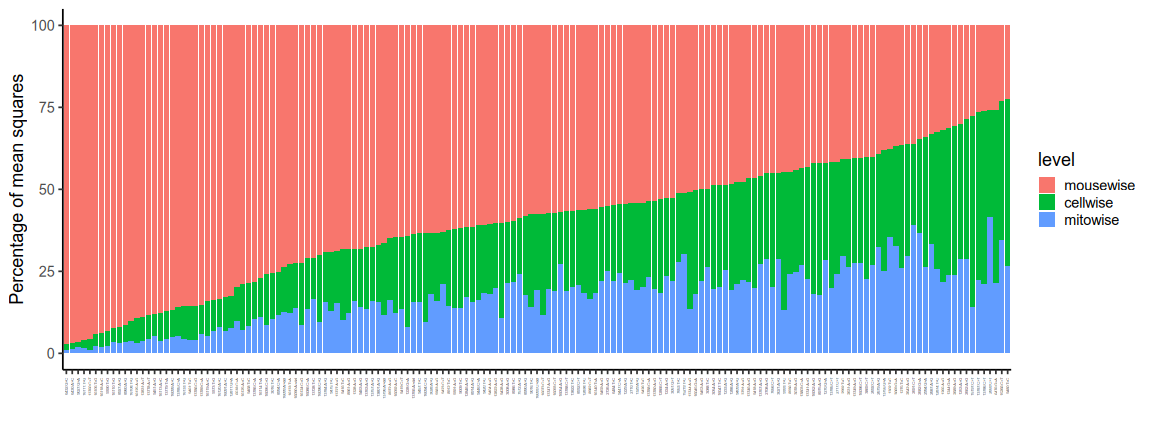

In [18]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 72)
ggplot(inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt, aes(x = posmut, fill = level, y = 100 * ms_prop)) + geom_bar(stat = "identity") + scale_x_discrete(limits = inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt[level == "mousewise"][order(-ms_prop)][, posmut]) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(size = 4, angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("Percentage of mean squares")

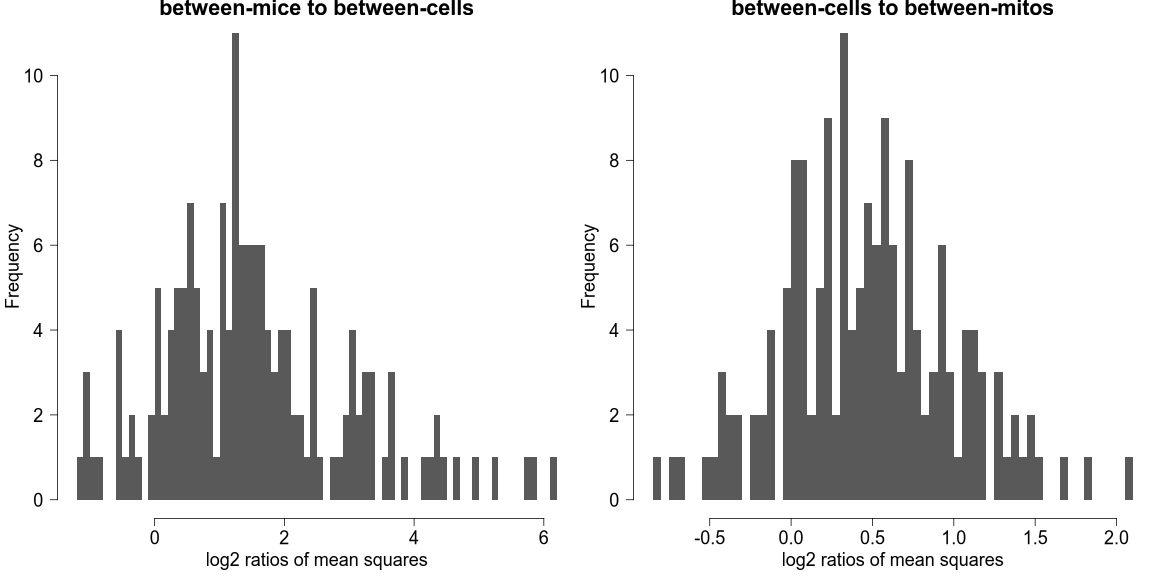

In [19]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 72)
par(ps = 18, las = 1, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 2), mar = c(4, 4, 1, 0), oma = c(0, 0, 0, 0), mgp = c(2.5, 1, 0))
hist(log2(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut["mousewise", ] / inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut["cellwise", ]), main = "between-mice to between-cells", xlab = "log2 ratios of mean squares", nclass = 100, border = FALSE, col = "#595959")
hist(log2(inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut["cellwise", ] / inherited_noctrl_altasin_nestedaov_msprop_bylevel_byposmut["mitowise", ]), main = "between-cells to between-mitos", xlab = "log2 ratios of mean squares", nclass = 100, border = FALSE, col = "#595959")

Top 5 least variable SNVs at mito-level and cell-level (uncentered)

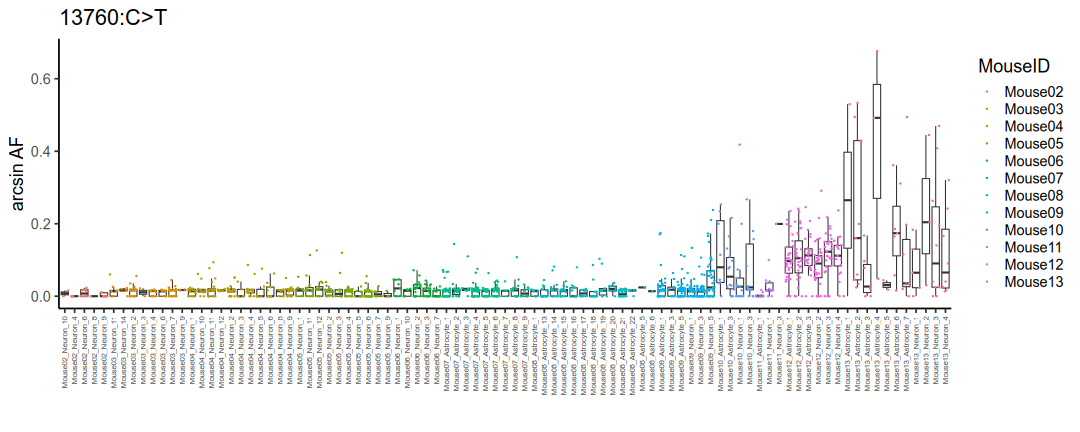

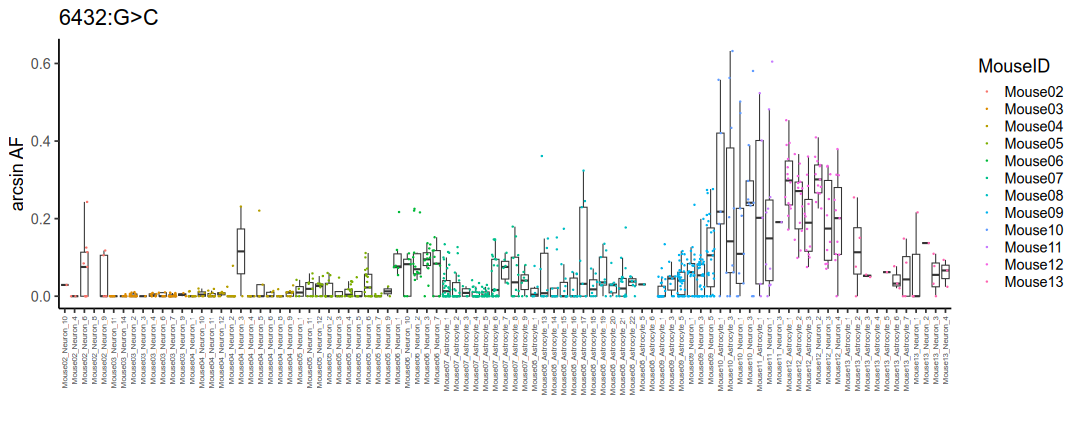

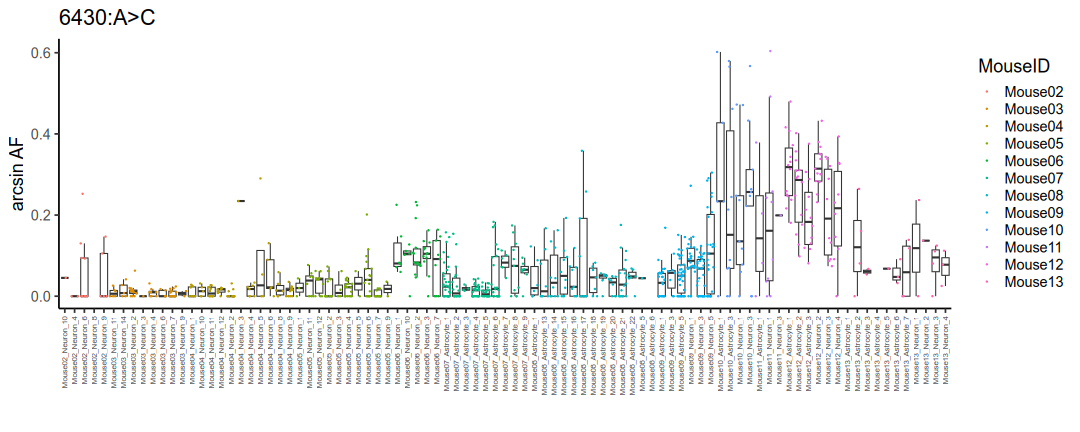

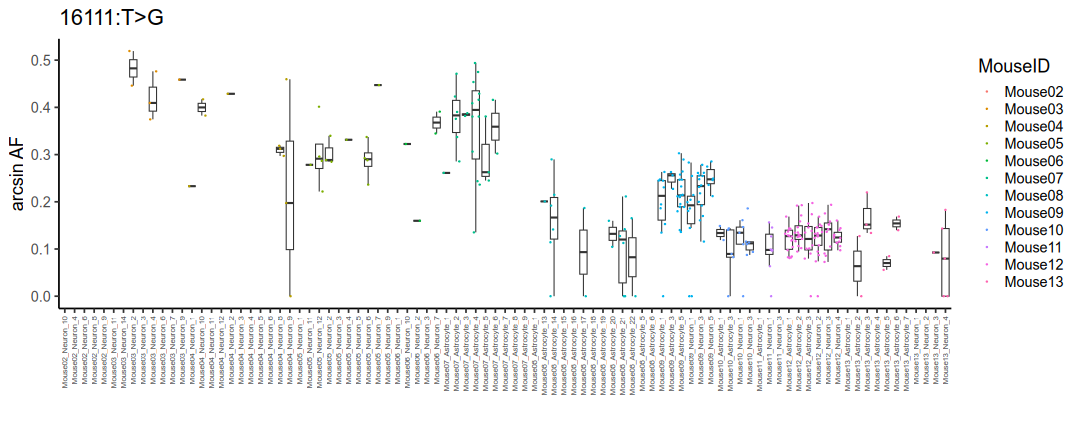

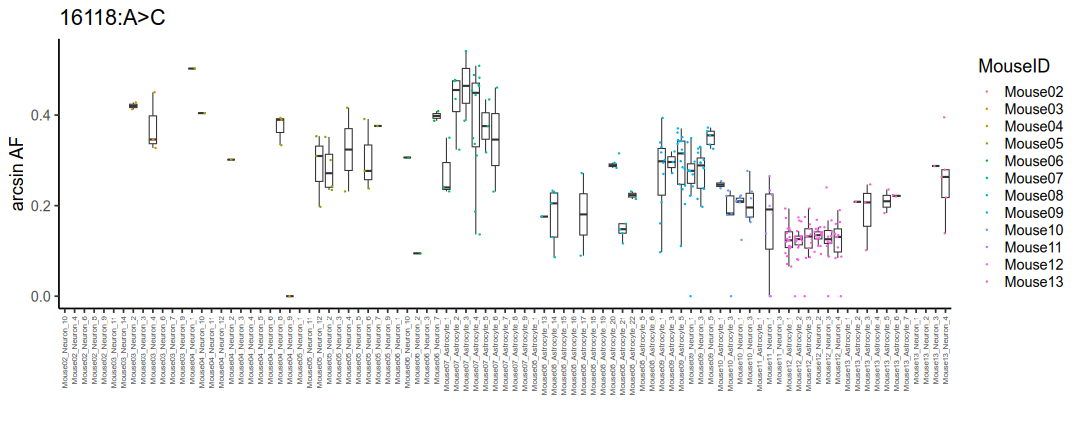

In [20]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 72)
for (posmut in inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt[level == "mitowise"][order(ms_prop)][, head(posmut, 5)]) {
    suppressWarnings(print(ggplot(inherited_noctrl_altasin_bymito_byposmut[MouseID != "Mouse16&17", c("MouseID", "CellUID", posmut), with = FALSE], aes(y = get(posmut), x = CellUID)) + geom_boxplot(outlier.color = NA) + geom_jitter(aes(col = MouseID), size = 0.5) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(size = 8, angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("arcsin AF") + ggtitle(posmut)))
}

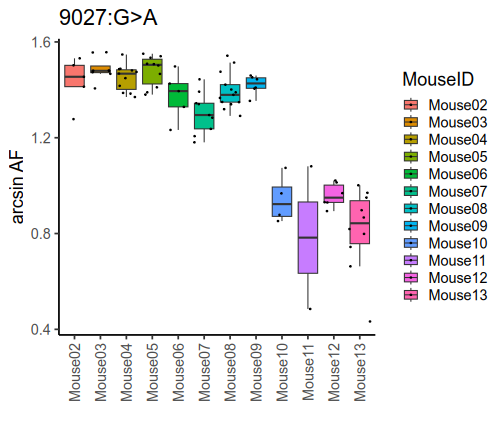

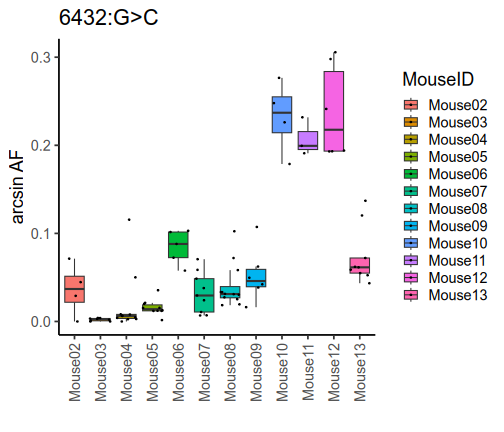

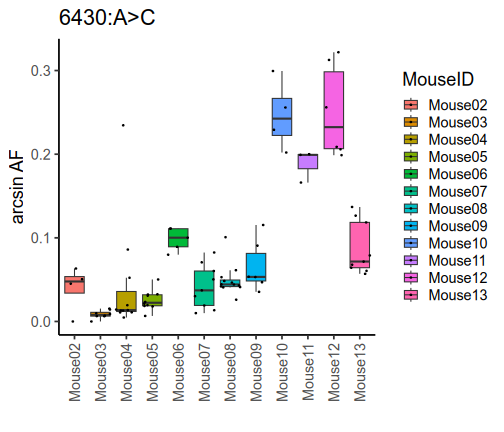

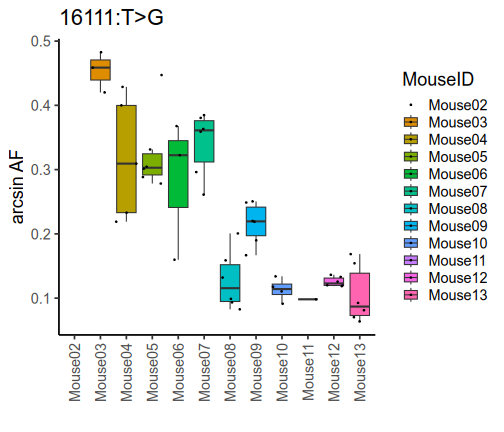

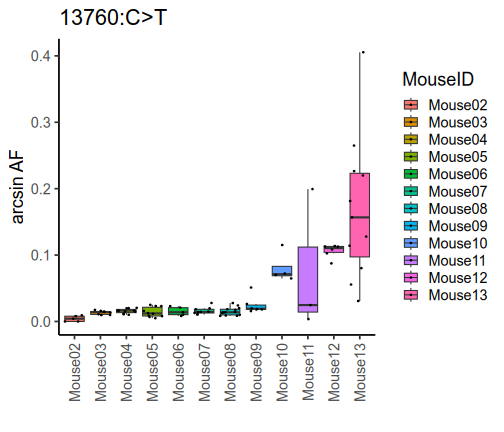

In [21]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
for (posmut in inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt[level == "cellwise"][order(ms_prop)][, head(posmut, 5)]) {
    suppressWarnings(print(ggplot(inherited_noctrl_altasin_bycell_byposmut[MouseID != "Mouse16&17"], aes(x = MouseID, y = get(posmut), fill = MouseID)) + geom_boxplot(outlier.color = NA) + geom_jitter(size = 0.6) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("arcsin AF") + ggtitle(posmut)))
}

Top 5 least variable SNVs at mito-level and cell-level (centered)

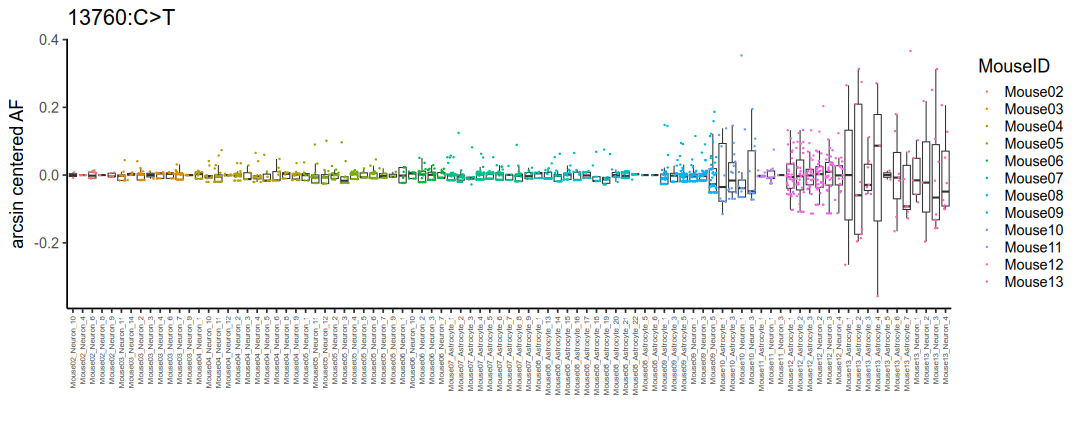

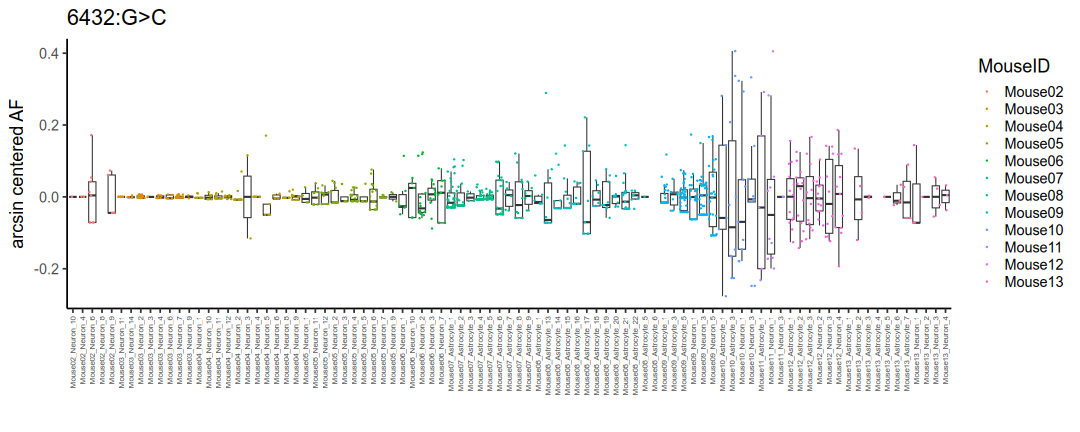

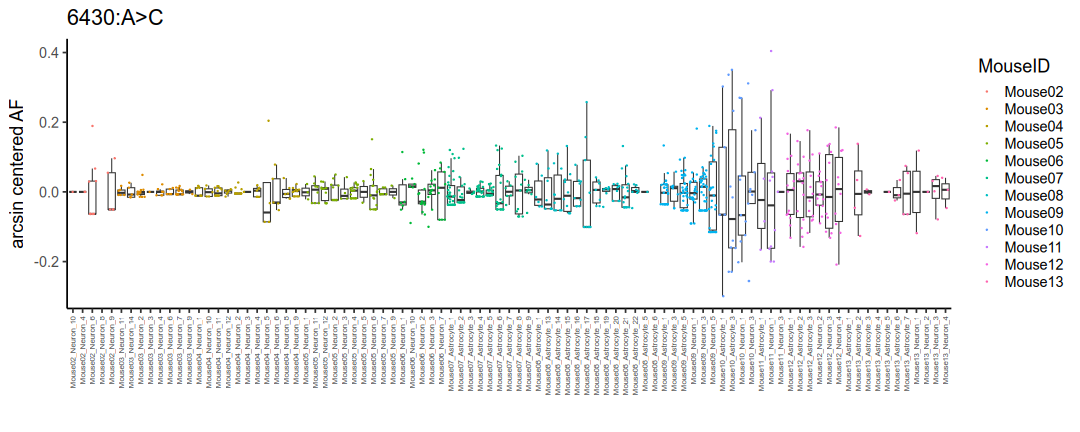

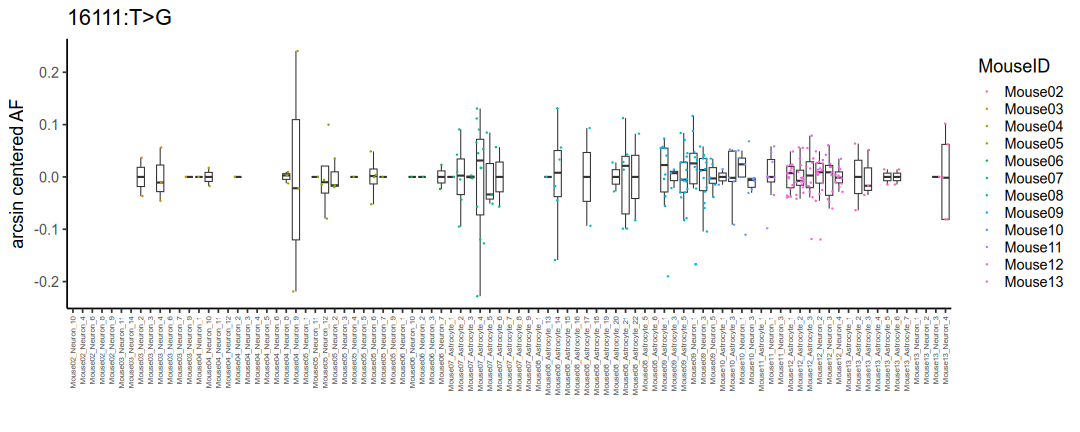

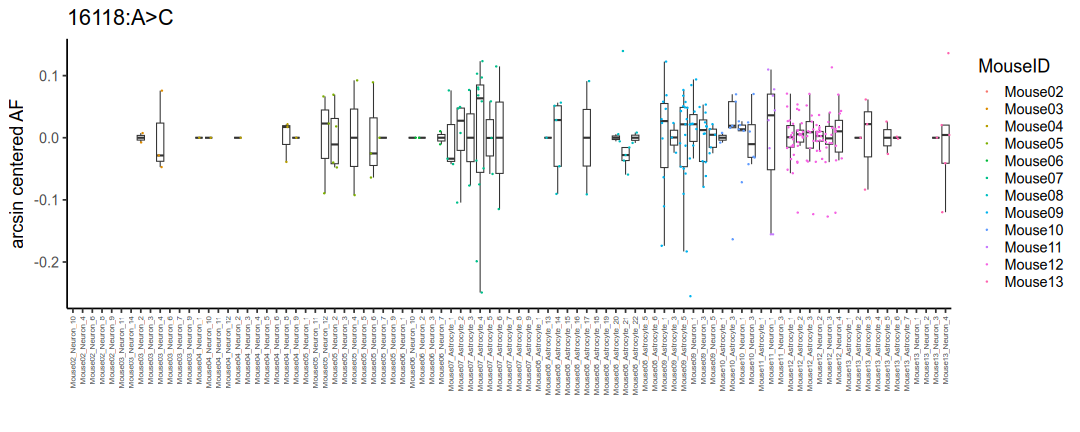

In [22]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 72)
for (posmut in inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt[level == "mitowise"][order(ms_prop)][, head(posmut, 5)]) {
    suppressWarnings(print(ggplot(inherited_noctrl_altasinctrd_bymito_byposmut[MouseID != "Mouse16&17", c("MouseID", "CellUID", posmut), with = FALSE], aes(y = get(posmut), x = CellUID)) + geom_boxplot(outlier.color = NA) + geom_jitter(aes(col = MouseID), size = 0.5) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(size = 8, angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("arcsin centered AF") + ggtitle(posmut)))
}

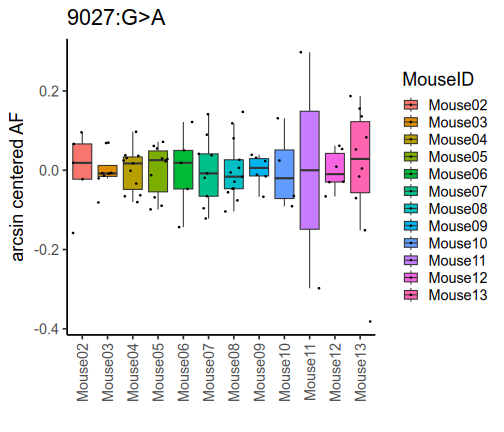

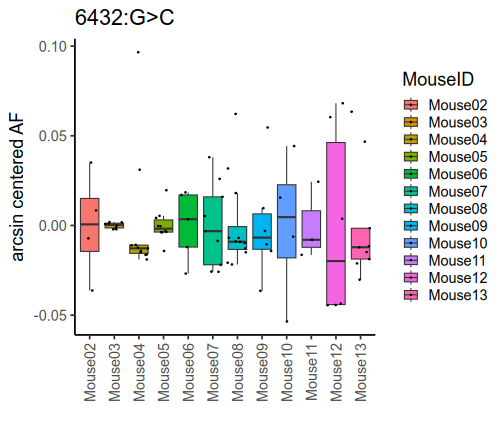

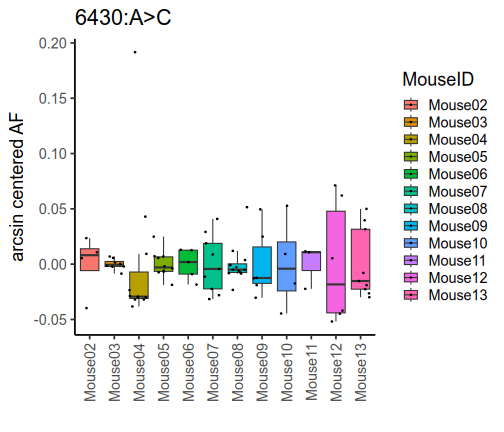

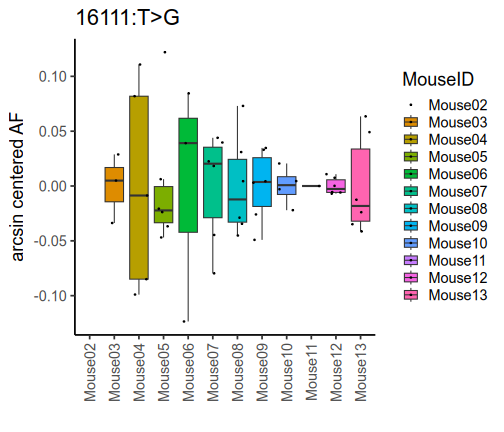

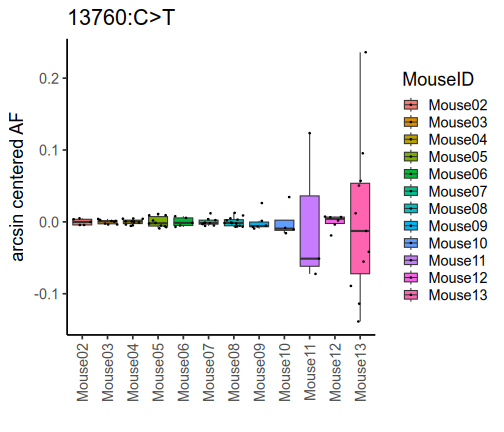

In [23]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
for (posmut in inherited_noctrl_altasin_nestedaov_bylevel_byposmut_dt[level == "cellwise"][order(ms_prop)][, head(posmut, 5)]) {
    suppressWarnings(print(ggplot(inherited_noctrl_altasinctrd_bycell_byposmut[MouseID != "Mouse16&17"], aes(x = MouseID, y = get(posmut), fill = MouseID)) + geom_boxplot(outlier.color = NA) + geom_jitter(size = 0.6) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("arcsin centered AF") + ggtitle(posmut)))
}

In order to rule out the possibility that the variation proportion is driven by the <5% AF noise, we went to shuffle the data and assess the null distribution of the mouse-wise, cell-wise and mito-wise variability proportion. The outcome is indeed 1/3, 1/3, 1/3.   
Let's run 1000 times permutation to get the null distribution.

In [24]:
set.seed(2022)
rnd_altasin_bymito_byposmut <- replicate(1000, {
    rnd <- copy(inherited_noctrl_altasin_bymito_byposmut)
    idx <- sample(seq(nrow(rnd)))
    rnd[, MouseID := MouseID[idx]]
    rnd[, CellUID := CellUID[idx]]
    rnd
}, simplify = FALSE)

rnd_altasin_nestedaov_bylevel_byposmut <- mclapply(1:1000, function(i) {
    sapply(inherited_posmuts, function(posmut) {
        X <- rnd_altasin_bymito_byposmut[[i]][MouseID != "Mouse16&17", c(posmut, "MouseID", "CellUID"), with = FALSE]
        names(X)[1] <- "VAF"
        mod <- aov(VAF ~ MouseID + Error(CellUID), data = X)
        summary(mod)
    }, simplify = FALSE)
}, mc.cores = 10)

In [25]:
rnd_altasin_nestedaov_df_bylevel_byposmut <- lapply(1:1000, function(i) { sapply(rnd_altasin_nestedaov_bylevel_byposmut[[i]], function(X) { structure(c(X[[1]][[1]][, "Df"], X[[2]][[1]][, "Df"]), names = c("mousewise", "cellwise", "mitowise")) }) })
rnd_altasin_nestedaov_ms_bylevel_byposmut <- lapply(1:1000, function(i) { sapply(rnd_altasin_nestedaov_bylevel_byposmut[[i]], function(X) { structure(c(X[[1]][[1]][, "Mean Sq"], X[[2]][[1]][, "Mean Sq"]), names = c("mousewise", "cellwise", "mitowise")) }) })

rnd_altasin_nestedaov_ftest_mousetocell_byposmut <- lapply(1:1000, function(i) { 
    sapply(inherited_posmuts, function(x) {
        df <- rnd_altasin_nestedaov_df_bylevel_byposmut[[i]][c("mousewise", "cellwise"), x]
        ms <- rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]][c("mousewise", "cellwise"), x]
        f <- ms["mousewise"] / ms["cellwise"]
        p <- pf(f, df1 = df["mousewise"], df2 = df["cellwise"], lower.tail = FALSE)
        c(fstat = unname(f), pval = unname(p))
    })
})
rnd_altasin_nestedaov_ftest_celltomito_byposmut <- lapply(1:1000, function(i) {
    sapply(inherited_posmuts, function(x) {
        df <- rnd_altasin_nestedaov_df_bylevel_byposmut[[i]][c("cellwise", "mitowise"), x]
        ms <- rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]][c("cellwise", "mitowise"), x]
        f <- ms["cellwise"] / ms["mitowise"]
        p <- pf(f, df1 = df["cellwise"], df2 = df["mitowise"], lower.tail = FALSE)
        c(fstat = unname(f), pval = unname(p))
    })
})

rnd_altasin_nestedaov_msprop_bylevel_byposmut <- lapply(1:1000, function(i) { t(t(rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]]) / colSums(rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]])) })

In [26]:
rnd_altasin_nestedaov_ftest_bylevel_byposmut <- lapply(1:1000, function(i) {
    t(rbind(
        local({rownames(rnd_altasin_nestedaov_df_bylevel_byposmut[[i]]) <- paste0("df_", rownames(rnd_altasin_nestedaov_df_bylevel_byposmut[[i]])); rnd_altasin_nestedaov_df_bylevel_byposmut[[i]] }), 
        local({rownames(rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]]) <- paste0("ms_", rownames(rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]])); rnd_altasin_nestedaov_ms_bylevel_byposmut[[i]] }), 
        local({rownames(rnd_altasin_nestedaov_msprop_bylevel_byposmut[[i]]) <- paste0("msprop_", rownames(rnd_altasin_nestedaov_msprop_bylevel_byposmut[[i]])); rnd_altasin_nestedaov_msprop_bylevel_byposmut[[i]] }),
        local({rownames(rnd_altasin_nestedaov_ftest_celltomito_byposmut[[i]]) <- paste0(rownames(rnd_altasin_nestedaov_ftest_celltomito_byposmut[[i]]), "_celltomito"); rnd_altasin_nestedaov_ftest_celltomito_byposmut[[i]] }) , 
        local({rownames(rnd_altasin_nestedaov_ftest_mousetocell_byposmut[[i]]) <- paste0(rownames(rnd_altasin_nestedaov_ftest_mousetocell_byposmut[[i]]), "_mousetocell"); rnd_altasin_nestedaov_ftest_mousetocell_byposmut[[i]]}) 
    ))
})

rnd_altasin_nestedaov_ftest_bylevel_byposmut <- lapply(1:1000, function(i) {
    data.table(
        perm = i,
        posmut = inherited_posmuts, 
        rnd_altasin_nestedaov_ftest_bylevel_byposmut[[i]]
    )
})
rnd_altasin_nestedaov_ftest_bylevel_byposmut <- rbindlist(rnd_altasin_nestedaov_ftest_bylevel_byposmut)
dim(rnd_altasin_nestedaov_ftest_bylevel_byposmut)

[1] 161000     15

In [ ]:
head(rnd_altasin_nestedaov_ftest_bylevel_byposmut)
fwrite(rnd_altasin_nestedaov_ftest_bylevel_byposmut, file = "Report/SNVs/hierarchy/rnd_altasin_nestedaov_ftest_bylevel_byposmut.csv.gz")

perm,posmut,df_mousewise,df_cellwise,df_mitowise,ms_mousewise,ms_cellwise,ms_mitowise,msprop_mousewise,msprop_cellwise,msprop_mitowise,fstat_celltomito,pval_celltomito,fstat_mousetocell,pval_mousetocell
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1224:A>G,11,76,657,0.001218332,0.001604831,0.001872797,0.2594425,0.3417472,0.3988103,0.8569167,0.79860661,0.7591649,0.678747441
1,1228:G>A,11,76,661,0.004753132,0.001683877,0.002032389,0.5612125,0.1988190,0.2399686,0.8285209,0.84723166,2.8227310,0.003843662
1,1229:A>G,11,76,661,0.002028446,0.001184334,0.001399402,0.4398018,0.2567840,0.3034142,0.8463149,0.81764417,1.7127309,0.086446372
1,1233:A>G,11,76,649,0.006408349,0.004292365,0.005612385,0.3928346,0.2631238,0.3440416,0.7648022,0.92823587,1.4929647,0.151742498
1,1244:G>A,11,76,666,0.001414092,0.001373401,0.003574134,0.2222846,0.2158883,0.5618271,0.3842611,0.99999948,1.0296279,0.429388015
1,1253:A>G,11,76,652,0.001995338,0.003085061,0.002415160,0.2662027,0.4115851,0.3222122,1.2773730,0.06444568,0.6467743,0.783062686


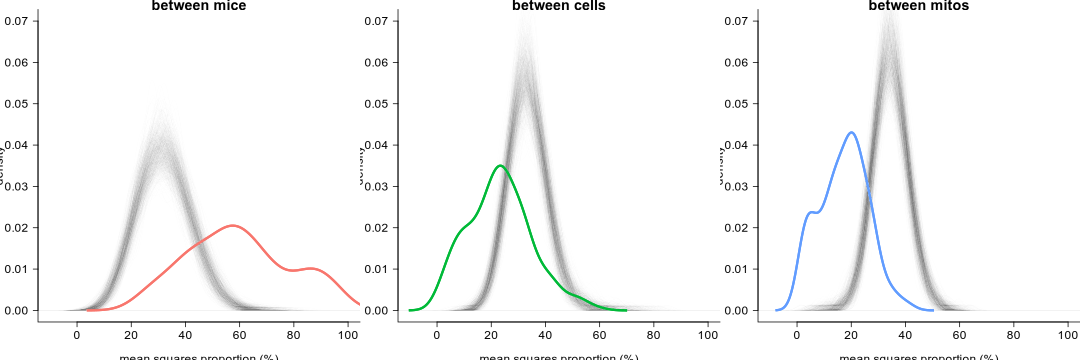

In [28]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 72)
par(ps = 18, lend = 2, las = 1, ljoin = 1, bty = "L", mfrow = c(1, 3), mar = c(4, 4, 1, 0), oma = c(0, 0, 0, 0), mgp = c(3.5, 1, 0))
invisible({
inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, (plot(density(100 * msprop_mousewise), col = scales::hue_pal()(3)[1], lwd = 3, xlim = c(-0.1, 1) * 100, ylim = c(0, 7)/100, main = "between mice", xlab = "mean squares proportion (%)", ylab = "density"))]
rnd_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_mousewise), col= "#00000001"), keyby = "perm"]
inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_mousewise), col = scales::hue_pal()(3)[1], lwd = 3)]

inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, (plot(density(100 * msprop_cellwise), col = scales::hue_pal()(3)[2], lwd = 3, xlim = c(-0.1, 1) * 100, ylim = c(0, 7)/100, main = "between cells", xlab = "mean squares proportion (%)", ylab = "density"))]
rnd_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_cellwise), col = "#00000001"), keyby = "perm"]
inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_cellwise), col = scales::hue_pal()(3)[2], lwd = 3)]

inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, (plot(density(100 * msprop_mitowise), col = scales::hue_pal()(3)[3], lwd = 3, xlim = c(-0.1, 1) * 100, ylim = c(0, 7)/100, main = "between mitos", xlab = "mean squares proportion (%)", ylab = "density"))]
rnd_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_mitowise), col= "#00000001"), keyby = "perm"]
inherited_noctrl_altasin_nestedaov_ftest_bylevel_byposmut[, lines(density(100 * msprop_mitowise), col = scales::hue_pal()(3)[3], lwd = 3)]
})

In [29]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggsignif_0.6.4    ggrepel_0.9.6     ggplot2_3.5.1     scales_1.3.0     
[5] pheatmap_1.0.12   reshape2_1.4.4    data.table_1.16.2

loaded via a namespace (a